In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 実験

> Test

- skip_showdoc: true
- skip_exec: true

In [ ]:
#|default_exp Exper

In [ ]:
#| hide
#| exporti
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen00, EKF, VA, simple
from matplotlib import pyplot as plt
from typing import Tuple
from functools import partial

ValueError: Class VApre_out not found in notebook inputs.

In [ ]:
#| export
@partial(jax.jit, static_argnames=['N', 'T'])
def exper(
    key: PRNGKeyArray,
    N: int, # $N$
    T: int, # $T$
    G: Float[Array, "{N} {N}"], # $\boldsymbol\Gamma$
    w0: Float[Array, "{N}"], # $\hat{\mathbf w}_{0/-1}$
    Sigma: Float[Array, "{N} {N}"], # $\boldsymbol\Sigma$
    P0: Float[Array, "{N} {N}"], # $\mathbf P_{0/-1}$
    propy1: Float, # $\text{p}_{y=1}p(y=1)$
    epsilon: Float =2**(-16) # $\epsilon\ge |\xi\\^{\text{new}}_t-\xi\\^{\text{old}}_t|$
):
  key_w, key_xy = jrd.split(key, 2)
  W = gen.gen_w(key_w, N, T, G, w0)
  X, Y = gen.gen_xy(key_xy, N, T, Sigma, W, propy1)
  Wtt_EKF, Ptt_EKF = EKF.EKF(N, T, X, Y, G, w0, P0)
  Wtt_VA, Ptt_VA, Xit_VA = VA.VApre(N, T, X, Y, G, w0, P0)
  Wtt_EM, Ptt_EM, Xit_EM = VA.VAEM(N, T, X, Y, G, w0, P0, epsilon)
  
  return X, Y, W, (Wtt_EKF, Ptt_EKF), (Wtt_VA, Ptt_VA, Xit_VA), (Wtt_EM, Ptt_EM, Xit_EM)

In [ ]:
#| eval: false
N=2
G = 1/2**9 * jnp.identity(N, dtype=jnp.float32)
Sigma = 10* jnp.identity(N, dtype=jnp.float32)
w0 = 0*jnp.ones((N,), dtype=jnp.float32)
propy1 = 0.5

X, Y, W, \
  (Wtt_EKF, Ptt_EKF), \
    (Wtt_VA, Ptt_VA, Xit_VA), \
      (Wtt_EM, Ptt_EM, Xit_EM) \
        = exper(
  key=jrd.PRNGKey(422), # 822 522
  N=N, 
  T=500, 
  G=G,
  w0=w0,
  Sigma=Sigma,
  P0=G,
  propy1=propy1)

<matplotlib.legend.Legend>

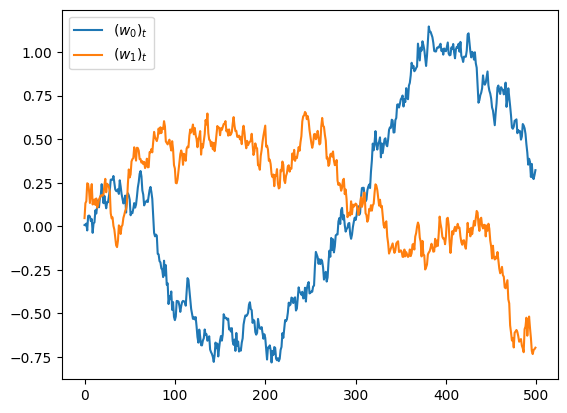

In [ ]:
#| eval: false
plt.plot(W[:,0], label=r"$(w_0)_t$")
plt.plot(W[:,1], label=r"$(w_1)_t$")
plt.legend()

<matplotlib.legend.Legend>

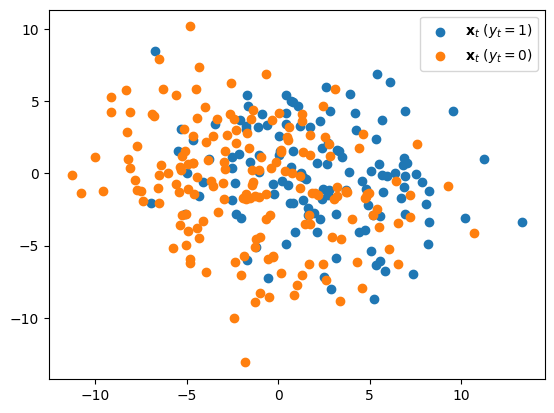

In [ ]:
#| eval: false
plt.scatter(X[Y==1][100:300,0], X[Y==1][100:300,1], label=r"$\mathbf{x}_t\ (y_t=1)$")
plt.scatter(X[Y==0][100:300,0], X[Y==0][100:300,1], label=r"$\mathbf{x}_t\ (y_t=0)$")
plt.legend()

<matplotlib.legend.Legend>

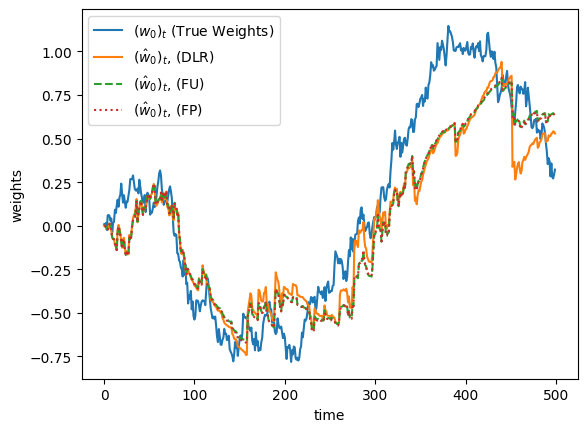

In [ ]:
#| eval: false
plt.plot(W[:,0], label=r"$(w_0)_t$ (True Weights)")
plt.plot(Wtt_EKF[:,0], "-", label=r"$(\hat{w}_0)_t$, (DLR)")
plt.plot(Wtt_VA[:,0], "--", label=r"$(\hat{w}_0)_t$, (FU)")
plt.plot(Wtt_EM[:,0], ":", label=r"$(\hat{w}_0)_t$, (FP)")
plt.xlabel("time")
plt.ylabel("weights")
plt.legend()

<matplotlib.legend.Legend>

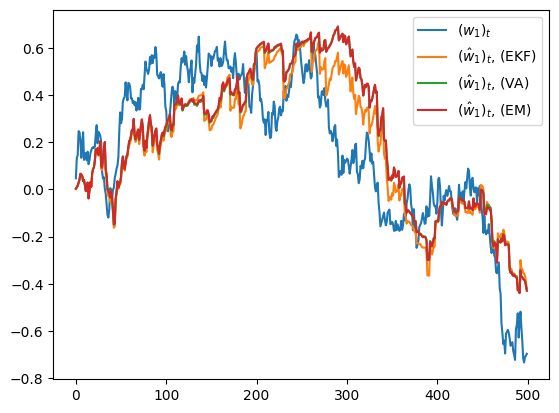

In [ ]:
#| eval: false
plt.plot(W[:,1], label=r"$(w_1)_t$")
plt.plot(Wtt_EKF[:,1], label=r"$(\hat{w}_1)_t$, (EKF)")
plt.plot(Wtt_VA[:,1], label=r"$(\hat{w}_1)_t$, (VA)")
plt.plot(Wtt_EM[:,1], label=r"$(\hat{w}_1)_t$, (EM)")
plt.legend()

<matplotlib.legend.Legend>

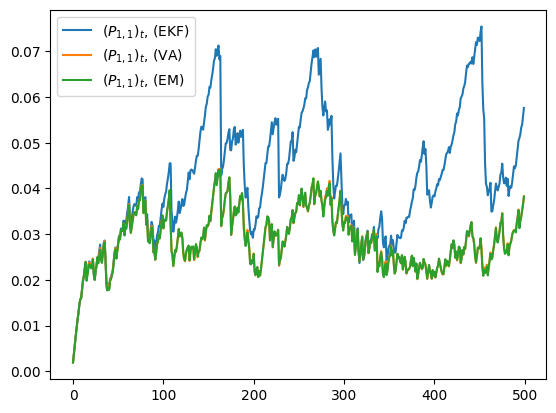

In [ ]:
#| eval: false
plt.plot(Ptt_EKF[:,0,0], label=r"$(P_{1,1})_t$, (EKF)")
plt.plot(Ptt_VA[:,0,0], label=r"$(P_{1,1})_t$, (VA)")
plt.plot(Ptt_EM[:,0,0], label=r"$(P_{1,1})_t$, (EM)")
plt.legend()

<matplotlib.legend.Legend>

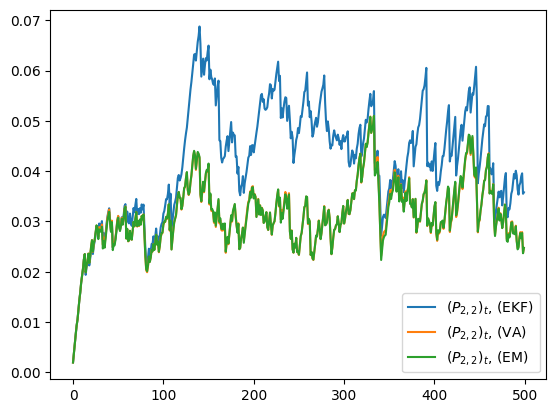

In [ ]:
#| eval: false
plt.plot(Ptt_EKF[:,1,1], label=r"$(P_{2,2})_t$, (EKF)")
plt.plot(Ptt_VA[:,1,1], label=r"$(P_{2,2})_t$, (VA)")
plt.plot(Ptt_EM[:,1,1], label=r"$(P_{2,2})_t$, (EM)")
plt.legend()

<matplotlib.legend.Legend>

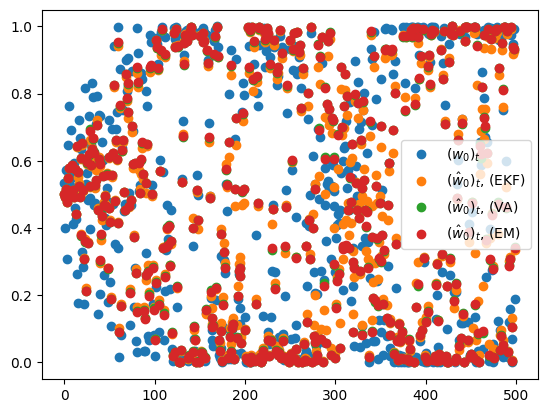

In [ ]:
#| eval: false
plt.plot(simple.losi(jnp.sum(W*X, axis=1)), 'o', label=r"$(w_0)_t$")
plt.plot(simple.losi(jnp.sum(Wtt_EKF*X, axis=1)), 'o', label=r"$(\hat{w}_0)_t$, (EKF)")
plt.plot(simple.losi(jnp.sum(Wtt_VA*X, axis=1)), 'o', label=r"$(\hat{w}_0)_t$, (VA)")
plt.plot(simple.losi(jnp.sum(Wtt_EM*X, axis=1)), 'o', label=r"$(\hat{w}_0)_t$, (EM)")
plt.legend()

<matplotlib.legend.Legend>

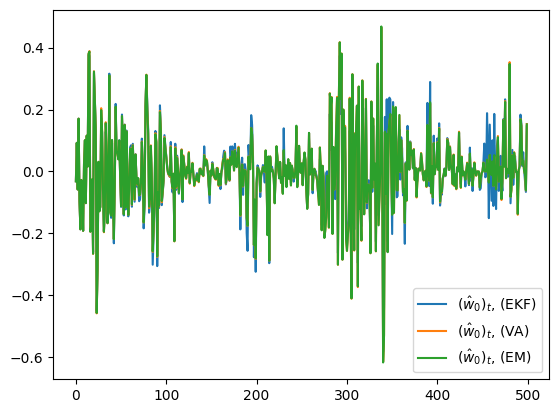

In [ ]:
#| eval: false
true_line = simple.losi(jnp.sum(W*X, axis=1))
plt.plot(simple.losi(jnp.sum(Wtt_EKF*X, axis=1)) - true_line, label=r"$(\hat{w}_0)_t$, (EKF)")
plt.plot(simple.losi(jnp.sum(Wtt_VA*X, axis=1)) - true_line, label=r"$(\hat{w}_0)_t$, (VA)")
plt.plot(simple.losi(jnp.sum(Wtt_EM*X, axis=1)) - true_line, label=r"$(\hat{w}_0)_t$, (EM)")
plt.legend()

In [ ]:
#| eval: false
print(jnp.sum((simple.losi(jnp.sum(Wtt_EKF*X, axis=1)) - true_line)**2))
print(jnp.sum((simple.losi(jnp.sum(Wtt_VA*X, axis=1)) - true_line)**2))
print(jnp.sum((simple.losi(jnp.sum(Wtt_EM*X, axis=1)) - true_line)**2))

7.2249694
7.6888556
7.6575623


In [ ]:
import pandas as pd

In [ ]:
#| eval: false
df1 = pd.read_csv("data.csv", sep="\t")
df1

,N,G,Sigma,propy1,err_EKF_sc,err_VA_sc,err_EM_sc
2,2.0,0.062500,0.50,0.5,0.093420,0.093336,0.093043
4,2.0,0.062500,1.00,0.5,0.093443,0.091697,0.091294
6,2.0,0.062500,2.00,0.5,0.093836,0.089228,0.088805
8,2.0,0.062500,4.00,0.5,0.094327,0.086147,0.085870
10,2.0,0.062500,8.00,0.5,0.096139,0.082455,0.082723
18,2.0,0.015625,2.00,0.5,0.093420,0.093336,0.093043
20,2.0,0.015625,4.00,0.5,0.093443,0.091697,0.091294
22,2.0,0.015625,8.00,0.5,0.093836,0.089228,0.088805
34,2.0,0.003906,8.00,0.5,0.093420,0.093336,0.093043
48,2.0,0.000244,0.25,0.5,0.039164,0.039163,0.039163


In [ ]:
#| eval: false
df1[(df1["err_EKF_sc"] < df1["err_VA_sc"])].groupby("N").count()

,G,Sigma,propy1,err_EKF_sc,err_VA_sc,err_EM_sc
N,,,,,,


In [ ]:
#| eval: false
df1["err_EKF_sc"] > df1["err_VA_sc"]

2      True
4      True
6      True
8      True
10     True
18     True
20     True
22     True
34     True
48     True
60     True
62     True
64     True
66     True
68     True
70     True
76     True
78     True
80     True
82     True
92     True
94     True
120    True
122    True
124    True
126    True
128    True
130    True
132    True
134    True
136    True
138    True
140    True
142    True
146    True
148    True
150    True
152    True
154    True
156    True
162    True
164    True
166    True
168    True
170    True
172    True
178    True
dtype: bool

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()